# eQTL Analysis

In [1]:
import copy
import glob
import os
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import seaborn as sns
import socket
import statsmodels.stats.multitest as smm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'eqtl_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
transcript_to_gene = pd.read_table(cpy.gencode_transcript_gene, header=None, 
                                   squeeze=True, index_col=0)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'secondary_eqtls', 'qvalues.tsv')
qvalues_sec = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'most_sig.tsv')
most_sig = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'secondary_eqtls', 'most_sig.tsv')
most_sig_sec = pd.read_table(fn, index_col=0)

gold_eqtls = pd.read_table(
    os.path.join(ciepy.root, 'output', 'eqtl_methods_exploration', 'gold_eqtls.tsv'),
    index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'gene_variant_pairs.tsv')
gene_variant = pd.read_table(fn, index_col=0)

## Summary

In [3]:
print('We detected eQTLs for {:,.0f} of {:,} genes tested.'.format(qvalues.sig.sum(), 
                                                                qvalues.shape[0]))

We detected eQTLs for 5,628 of 17,769 genes tested.


In [4]:
print('{:,.0f} of {:,} significant genes have second eQTLs.'.format(qvalues_sec.sig.sum(), 
                                                                    qvalues_sec.shape[0]))

540 of 5,628 significant genes have second eQTLs.


In [21]:
most_sig = most_sig.join(qvalues, rsuffix='_perm')

In [23]:
print('Number of genes with variant type as lead variant (ties allowed):')
s = set(most_sig[most_sig.sig].gene + ':' + most_sig[most_sig.sig].vtype)
pd.Series([x.split(':')[1] for x in s]).value_counts()

Number of genes with variant type as lead variant (ties allowed):


snp    4892
del     712
ins     626
cnv      89
dtype: int64

In [122]:
sum(gene_variant.marker_id.apply(lambda x: 'CNV' in x))

895

## Comparison to GTEx Multi-Tissue eQTLs

I want to visualize some of the permutation $p$-values versus the "real" $p$-value
for some of the GTEx multi-tissue eQTLs.

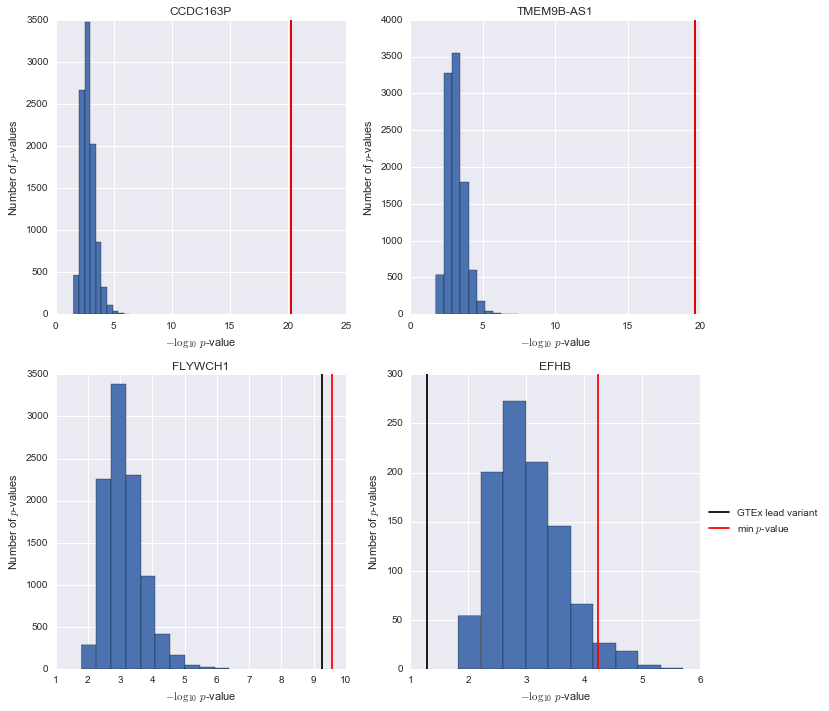

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i, g in enumerate(list(set(most_sig.index) & set(gold_eqtls.index))[0:4]):
    ax = axs[i]
    fn = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'results',
                      g, '{}.tsv'.format(g))
    min_fn = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'results', 
                          g, 'minimum_pvalues.tsv')
    if os.path.exists(min_fn):
        res = ciepy.read_emmax_output(fn)
        #t = res[res.MARKER_ID.apply(lambda x: gold_eqtls.ix[g, 'rsid'] in x)]
        t = res[res.BEG == gold_eqtls.ix[g, 'start']]
        min_pvals = pd.read_table(min_fn, header=None, squeeze=True)
        
        ax = (-np.log10(min_pvals)).hist(ax=ax)
        ax.set_ylabel('Number of $p$-values')
        ax.set_xlabel('$-\log_{10}$ $p$-value')
        ya, yb = ax.get_ylim()
        ax.vlines(-np.log10(t.PVALUE), ya, yb, label='GTEx lead variant')
        ax.vlines(-np.log10(res.PVALUE.min()), ya, yb, colors=['red'], label='min $p$-value')
        ax.set_title('{}'.format(gene_info.ix[g, 'gene_name']));
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'gtex_comparison.pdf'), 
            bbox_extra_artists=(lgd,), bbox_inches='tight')

The black line shows the $p$-value for the GTEx SNV. The red line shows the smallest $p$-value that
I observe for the gene. We can see that most of these genes are highly significant compared to the 
permutation $p$-values.

## Distance to Nearest TSS

In [41]:
ind = (most_sig.chrom + ':' + most_sig.start.astype(str) + '-' +
       most_sig.end.astype(str) + ':' + pd.Series(most_sig.index, index=most_sig.index))
most_sig.index = ind

In [43]:
tss = pbt.BedTool(cpy.gencode_tss_bed)
tss_df = tss.to_dataframe()
tss_df['gene'] = tss_df.name.apply(lambda x: transcript_to_gene[x.split('_')[0]])
s = '\n'.join(tss_df.gene + '\t' + tss_df.start.astype(str) + '\t' +
              tss_df.end.astype(str) + '\t' + tss_df.name + '\t' + 
              tss_df.score + '\t' + tss_df.strand) + '\n'
fake_tss = pbt.BedTool(s, from_string=True)
fake_tss = fake_tss.sort()

s = '\n'.join(most_sig.gene + '\t' + most_sig.start.astype(str) + '\t' + 
              most_sig.end.astype(str) + '\t.\t' + most_sig.chrom) + '\n'
fake_most_sig_bt = pbt.BedTool(s, from_string=True)
fake_most_sig_bt = fake_most_sig_bt.sort()

res = fake_most_sig_bt.closest(fake_tss, D='b', sorted=True)
res_df = res.to_dataframe()
res_df.index = (res_df.score + ':' + res_df.start.astype(str) + '-' + 
                res_df.end.astype(str) + ':' + res_df.chrom)

res_df['variant_gene'] = res_df.index
res_df = res_df.drop_duplicates(subset=['variant_gene'])

most_sig['tss_dist'] = res_df.ix[most_sig.index, 'blockStarts']
most_sig['tss_dist_abs'] = most_sig.tss_dist.abs()

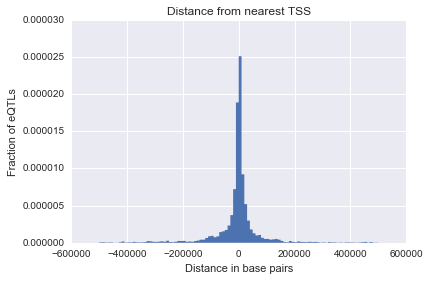

In [65]:
n,b,p = plt.hist(most_sig[most_sig.sig == 1].tss_dist, 
                 bins=np.arange(-500000, 510000, 10000),
                 normed=True, histtype='stepfilled',
                 linewidth=0)
plt.title('Distance from nearest TSS')
plt.ylabel('Fraction of eQTLs')
plt.xlabel('Distance in base pairs');

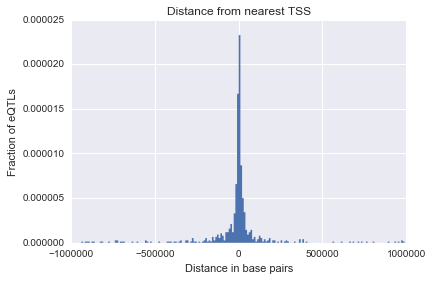

In [67]:
n,b,p = plt.hist(most_sig[(most_sig.sig == 1) & (most_sig.vtype == 'ins')].tss_dist, 
                 bins=np.arange(-1000000, 1010000, 10000),
                 normed=True, histtype='stepfilled', linewidth=0)
plt.title('Distance from nearest TSS')
plt.ylabel('Fraction of eQTLs')
plt.xlabel('Distance in base pairs');

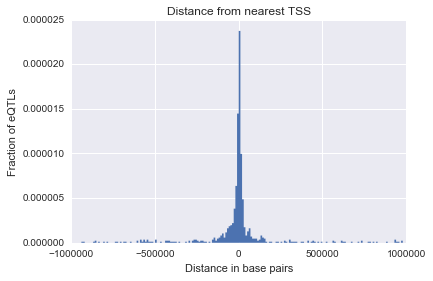

In [69]:
n,b,p = plt.hist(most_sig[(most_sig.sig == 1) & (most_sig.vtype == 'del')].tss_dist, 
                 bins=np.arange(-1000000, 1010000, 10000),
                 normed=True, histtype='stepfilled', linewidth=0)
plt.title('Distance from nearest TSS')
plt.ylabel('Fraction of eQTLs')
plt.xlabel('Distance in base pairs');

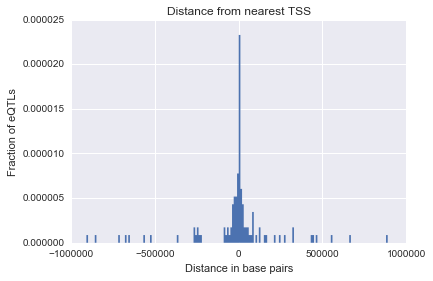

In [70]:
n,b,p = plt.hist(most_sig[(most_sig.sig == 1) & (most_sig.vtype == 'cnv')].tss_dist, 
                 bins=np.arange(-1000000, 1010000, 10000),
                 normed=True, histtype='stepfilled', linewidth=0)
plt.title('Distance from nearest TSS')
plt.ylabel('Fraction of eQTLs')
plt.xlabel('Distance in base pairs');

In [71]:
most_sig = most_sig.sort_values(by='tss_dist_abs')
most_sig_single = most_sig.drop_duplicates(subset=['gene'])
most_sig_single.index = most_sig_single.gene

In [109]:
most_sig.to_csv(os.path.join(outdir, 'most_sig.tsv'), sep='\t')
most_sig_single.to_csv(os.path.join(outdir, 'most_sig_single.tsv'), sep='\t')

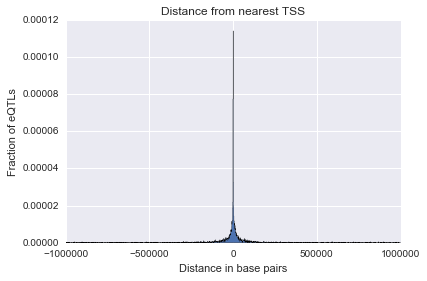

In [75]:
n,b,p = plt.hist(most_sig_single[most_sig_single.sig == 1].tss_dist, 
                 bins=np.arange(-1000000, 1001000, 1000),
                 normed=True, histtype='stepfilled')
plt.title('Distance from nearest TSS')
plt.ylabel('Fraction of eQTLs')
plt.xlabel('Distance in base pairs');

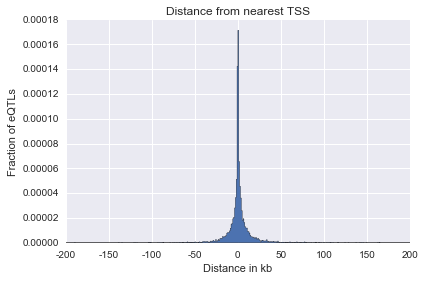

In [14]:
n,b,p = plt.hist(most_sig_single[most_sig_single.sig == 1].tss_dist, 
                 bins=np.arange(-200000, 201000, 1000),
                 normed=True, histtype='stepfilled')
plt.title('Distance from nearest TSS')
plt.ylabel('Fraction of eQTLs')
plt.xlabel('Distance in kb')
x = plt.xticks()
plt.xticks(x[0], [int(t) for t in x[0] / 1000])
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'sig_snv_tss_dist.pdf'))

The above two plots are the same data at different $x$-axis limits. The first plot
in particular is meant to be comparable to Fig. S9 from the GTEx paper.

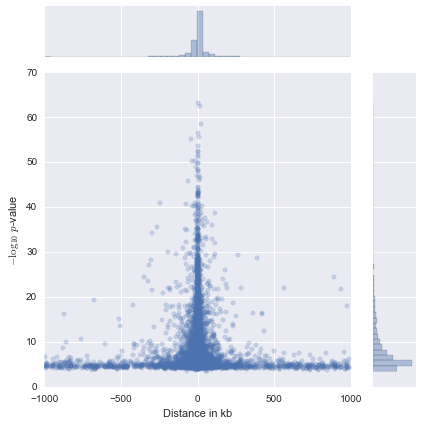

In [76]:
ax = sns.jointplot(most_sig_single[most_sig_single.sig == 1].tss_dist / 1000,
                   -np.log10(most_sig_single[most_sig_single.sig == 1].pvalue),
                   stat_func=None, alpha=0.25)
ax.set_axis_labels(xlabel='Distance in kb',
                   ylabel='$-\log_{10}$ $p$-value')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'sig_pvalue_tss_dist.pdf'))

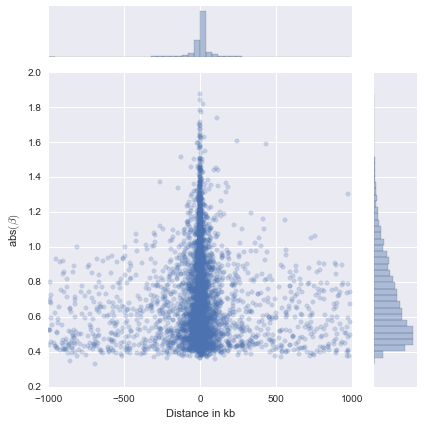

In [77]:
ax = sns.jointplot(most_sig_single[most_sig_single.sig == 1].tss_dist / 1000,
                   most_sig_single[most_sig_single.sig == 1].beta.abs(),
                   stat_func=None, alpha=0.25)
ax.set_axis_labels(xlabel='Distance in kb', ylabel='abs$(\\beta)$')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'sig_beta_tss_dist.pdf'))

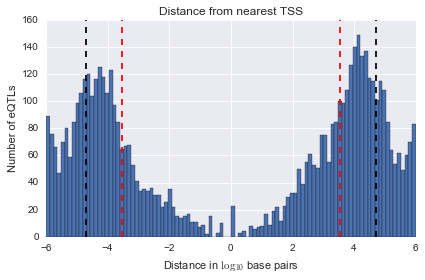

In [79]:
dists = most_sig_single[most_sig_single.sig == 1].tss_dist
a = dists[dists >= 0]
b = -dists[dists < 0]
r = plt.hist(list(np.log10(a + 1)) + list(-np.log10(b + 1)),
             bins=100)
plt.title('Distance from nearest TSS')
plt.ylabel('Number of eQTLs')
plt.xlabel('Distance in $\log_{10}$ base pairs')
ya, yb = plt.ylim()
plt.vlines(np.log10(50000), ya, yb, linestyles='--')
plt.vlines(-np.log10(50000), ya, yb, linestyles='--')
plt.vlines(np.log10(3500), ya, yb, linestyles='--', color='red')
plt.vlines(-np.log10(3500), ya, yb, linestyles='--', color='red')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'sig_snv_tss_log_dist.pdf'))

Grubert et al. defined distal as greater than 50 kb away (outside of the black lines above). 
They searched for *cis* QTLs within 2kb of peak boundaries or $\pm$3.5kb around the TSS (inside
of the red lines above). I'd like to go back and see what they thought about the intermediate region.

I'm somewhat surprised that there are more potential QTNs downstream of TSSs. In the plot, a positive 
distance indicates that the SNV is downstream of the TSS (relative to the strand of the TSS). However,
only about half of the SNVs are actually closest to the TSS of their eQTL gene. It may be the
case that this distribution would look a little different if I found the closest TSS for the eQTL
gene.

## Gencode Gene Type

In [ ]:
t = pd.DataFrame(0, index=set(gene_info.gene_type), columns=['sig', 'not_sig'])
vc = gene_info.ix[qvalues[qvalues.sig].index, 'gene_type'].value_counts()
t.ix[vc.index, 'sig'] = vc
vc = gene_info.ix[qvalues[qvalues.sig == False].index, 'gene_type'].value_counts()
t.ix[vc.index, 'not_sig'] = vc
t = t[t.sum(axis=1) > 1]
t['total'] = t.sum(axis=1)
#t.sort_values(by='total', inplace=True, ascending=False)
t.sort_values(by='total', inplace=True)

In [125]:
sns.set_context('talk', font_scale=1.5)

In [134]:
t.tail()

,sig,not_sig,total
processed_transcript,84,135,219
antisense,273,645,918
lincRNA,352,693,1045
pseudogene,330,1053,1383
protein_coding,4522,9311,13833


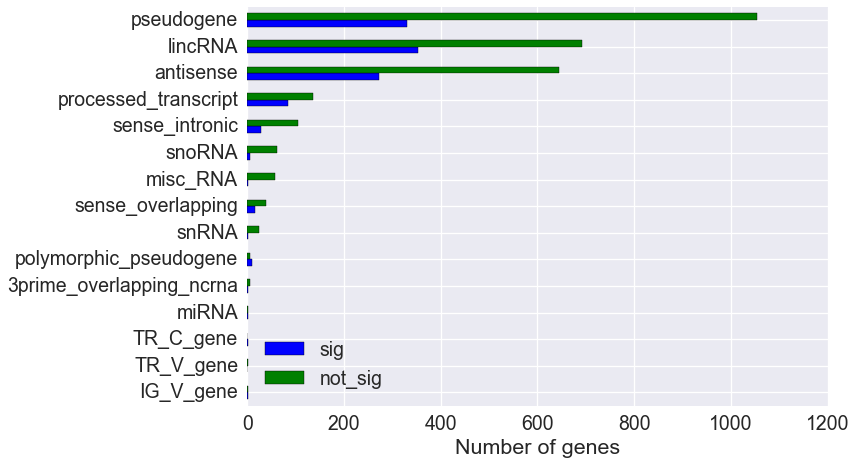

In [132]:
t.drop('protein_coding')[['sig', 'not_sig']].plot(kind='barh')
plt.xlabel('Number of genes');

## Manhattan and Expression Plots

In [100]:
fn = os.path.join(ciepy.root, 'private_output', 'eqtl_input', 
                  'filtered_all', '0000.vcf.gz')
vcf_reader = pyvcf.Reader(open(fn), compressed=True)
res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'results', 
                                 '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])

sig = qvalues[qvalues.sig == 1]
sig = sig.sort_values('qvalue')

In [111]:
def eqtl_summary(g, left=None, right=None, fn_root=None):
    res = ciepy.read_emmax_output(res_fns[g])
    res = res.sort_values('PVALUE')
    if gene_info.ix[most_sig_single.ix[g, 'gene'], 'strand'] == '+':
        gene_left = gene_info.ix[most_sig_single.ix[g, 'gene'], 'start']
        gene_right = gene_info.ix[most_sig_single.ix[g, 'gene'], 'end']
    else:
        gene_right = gene_info.ix[most_sig_single.ix[g, 'gene'], 'start']
        gene_left = gene_info.ix[most_sig_single.ix[g, 'gene'], 'end']
    if left:
        res = res[res.BEG >= gene_left - left]
    if right:
        res = res[res.BEG <= gene_right + right]
    plt.figure()
    plt.scatter(res.BEG, -np.log10(res.PVALUE), color='grey', alpha=0.5)
    plt.xlim(res.BEG.min(), res.BEG.max())
    ya = 0
    yb = (-np.log10(res.PVALUE)).max() + 1
    plt.ylim(ya, yb)
#     plt.vlines(most_sig_single.ix[g, 'tss_start'], ya, yb, color='blue',
#                linestyles='--', alpha=0.5)
    poly = plt.Polygon([[gene_left, 0.9 * yb], [gene_left, yb], [gene_right, 0.95 * yb]], 
                       closed=True, facecolor='blue', edgecolor='none')
    plt.gca().add_patch(poly)
    #most_sig_single.ix[g, 'tss_start']
    plt.xlabel('Genomic position')
    plt.ylabel('$-\log_{10}$ $p$-value')
    plt.title('Manhattan plot for {}'.format(gene_info.ix[g, 'gene_name']));
    if fn_root:
        plt.tight_layout()
        plt.savefig('{}_manhattan.pdf'.format(fn_root))
        
    t =  vcf_reader.fetch(res.CHROM.values[0], 
                          res.BEG.values[0], 
                          res.BEG.values[0] + 1)
    r = t.next()
    tdf = pd.DataFrame(exp.ix[g])
    tdf.columns = ['expression']
    tdf['genotype'] = 0
    hets = set(exp.columns) & set([s.sample for s in r.get_hets()])
    tdf.ix[hets, 'genotype'] = 1
    alts = set(exp.columns) & set([s.sample for s in r.get_hom_alts()])
    tdf.ix[alts, 'genotype'] = 2
    plt.figure()
    #sns.lmplot(x='genotype', y='expression', data=tdf)
    ax = sns.violinplot(x='genotype', y='expression', data=tdf, color='grey',
                    order=[0, 1, 2], scale='count')
    sns.regplot(x='genotype', y='expression', data=tdf, scatter=False, color='red')
    ya, yb = plt.ylim()
    plt.text(0, yb, 'n={}'.format(sum(tdf.genotype == 0)), 
             verticalalignment='top', horizontalalignment='center')
    plt.text(1, yb, 'n={}'.format(sum(tdf.genotype == 1)), 
             verticalalignment='top', horizontalalignment='center')
    plt.text(2, yb, 'n={}'.format(sum(tdf.genotype == 2)), 
             verticalalignment='top', horizontalalignment='center')
    plt.title('Expression vs. genotype for {}'.format(gene_info.ix[g, 'gene_name']));
    if fn_root:
        plt.tight_layout()
        plt.savefig('{}_violin.pdf'.format(fn_root))

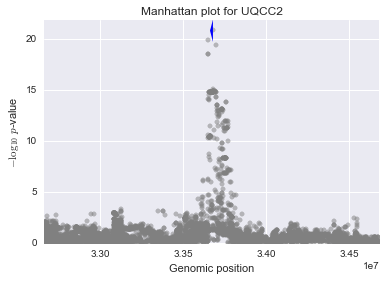

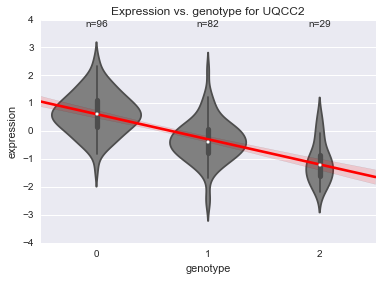

In [112]:
eqtl_summary(sig.index[0])

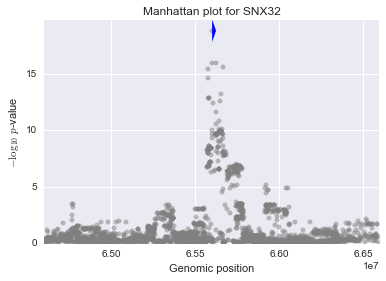

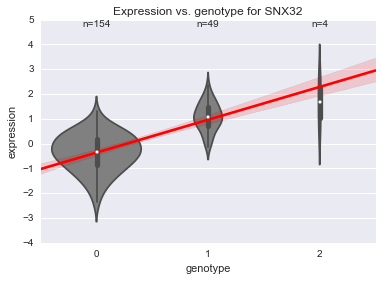

In [113]:
eqtl_summary(sig.index[5])

## GO Term Enrichment

## Pluripotency Genes

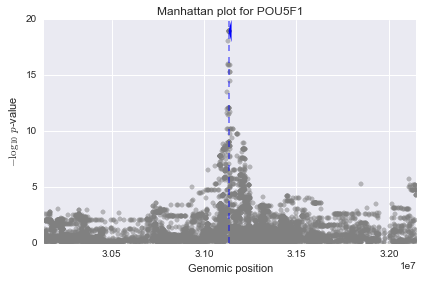

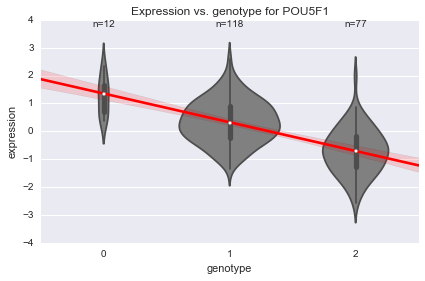

In [31]:
pgenes = ['LIN28A', 'POU5F1', 'SOX2', 'NANOG', 'MYC', 'KLF4', 'ZFP42']
for g in pgenes:
    i = gene_info[gene_info.gene_name == g].index[0]
    if i in sig.index:
        eqtl_summary(i, fn_root=os.path.join(outdir, '{}_summary'.format(g)))

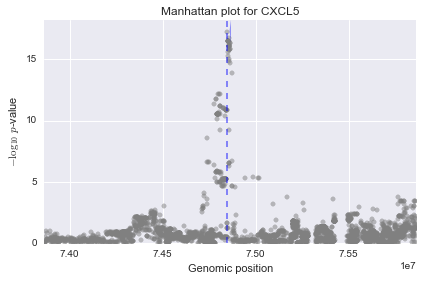

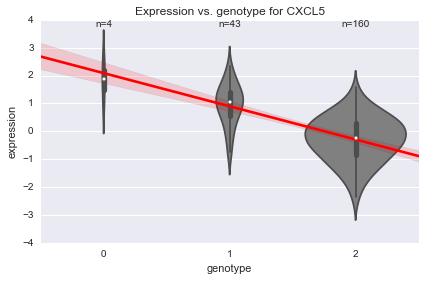

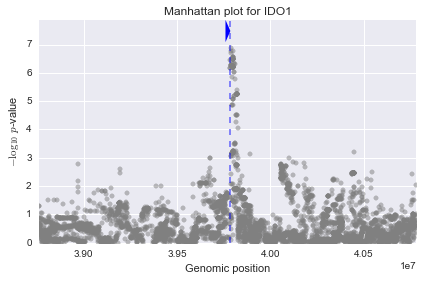

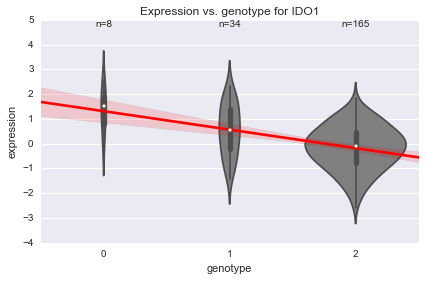

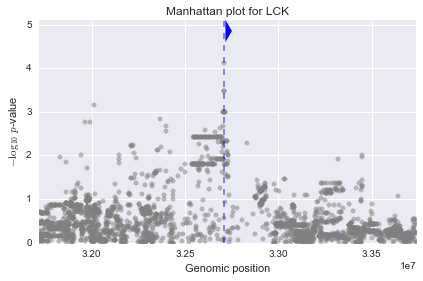

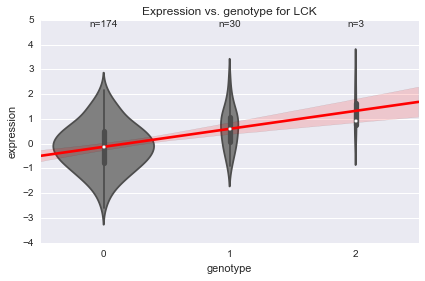

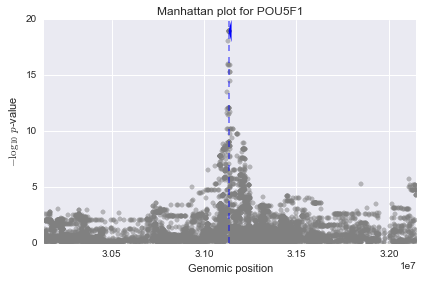

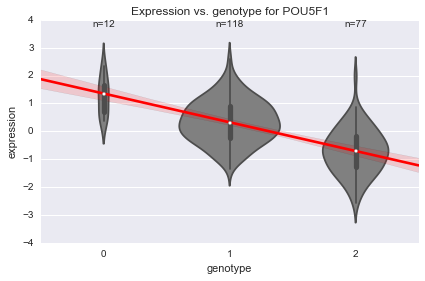

In [32]:
# Markers of pluripotency from http://www.nature.com/nbt/journal/v33/n11/full/nbt.3387.html.
pgenes = ['CXCL5', 'IDO1', 'LCK', 'TRIM22', 'DNMT3B', 'HESX1', 'SOX2', 'POU5F1', 'NANOG']
for g in pgenes:
    i = gene_info[gene_info.gene_name == g].index[0]
    if i in sig.index:
        eqtl_summary(i, fn_root=os.path.join(outdir, '{}_summary'.format(g)))

BRIX1 
COMMD3 
CRABP2 
EDNRB 
FGF4 
FGF5 
FOXD3 
GABRB3 
GAL 
GDF3 
GRB7 
HCK 
IFITM1 
IL6ST 
KIT 
LIFR 
NODAL 
PTEN 
SFRP2 


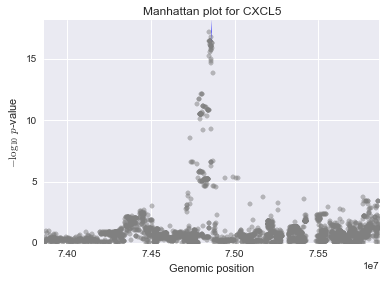

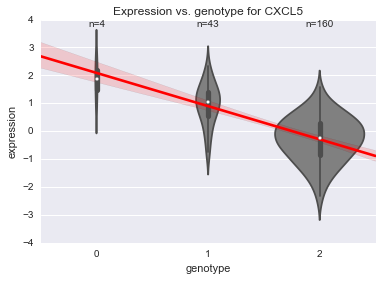

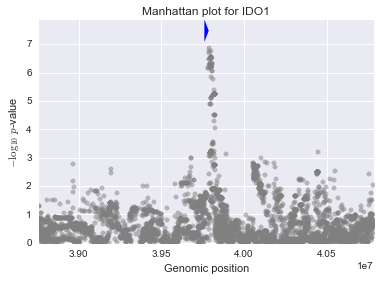

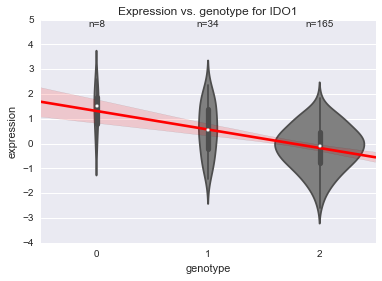

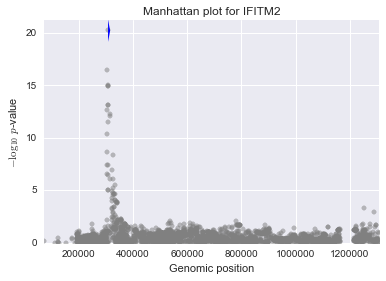

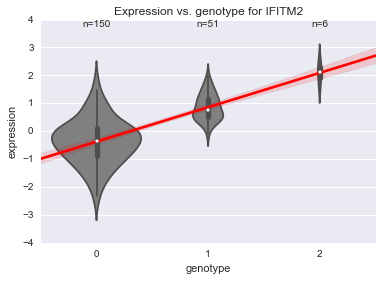

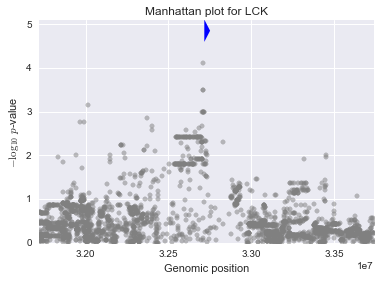

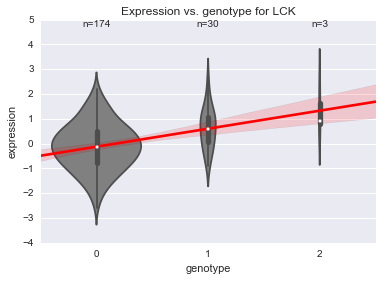

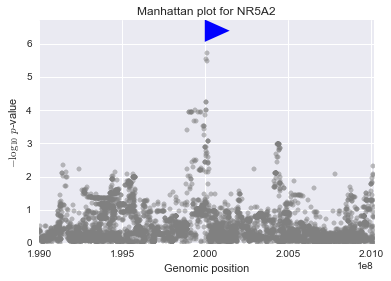

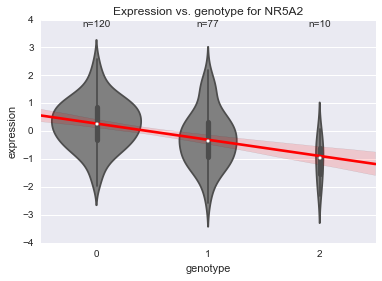

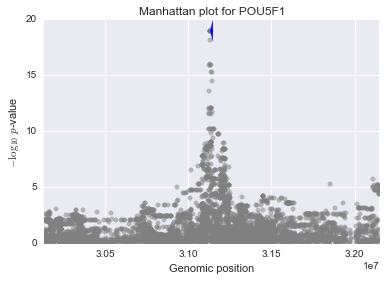

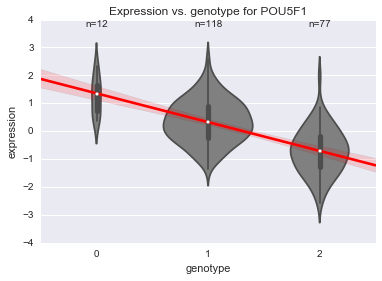

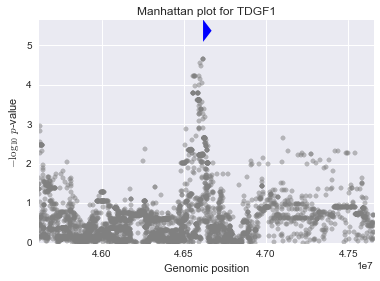

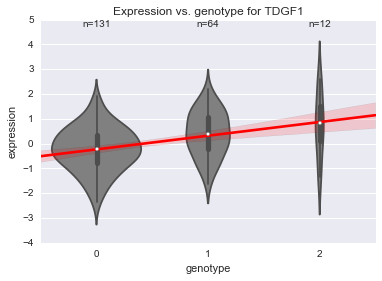

In [114]:
genes = [u'BRIX1 ', u'CD9', u'COMMD3 ', u'CRABP2 ', u'CXCL5', u'DIAPH2',
         u'DNMT3B', u'EDNRB ', u'FGF4 ', u'FGF5 ', u'FOXD3 ', u'GABRB3 ',
         u'GAL ', u'GBX2', u'GDF3 ', u'GRB7 ', u'HCK ', u'HESX1', u'IDO1',
         u'IFITM1 ', u'IFITM2', u'IGF2BP2', u'IL6ST ', u'KIT ', u'LCK', u'LIFR ',
         u'LIN28A', u'NANOG', u'NODAL ', u'NOG', u'NR5A2', u'NR6A1', u'PODXL',
         u'POU5F1', u'PTEN ', u'SEMA3A', u'SFRP2 ', u'SOX2', u'TDGF1', u'TERT',
         u'TFCP2L1', u'TRIM22', u'UTF1', u'ZFP42']
for g in genes:
    if g in gene_info.gene_name.values:
        i = gene_info[gene_info.gene_name == g].index[0]
        if i in sig.index:
            eqtl_summary(i)#, fn_root=os.path.join(outdir, '{}_summary'.format(g)))
    else:
        print(g)

In [65]:
pgenes = ['LIN28A', 'POU5F1', 'SOX2', 'NANOG', 'MYC', 'KLF4', 'ZFP42']
for g in pgenes:
    i = gene_info[gene_info.gene_name == g].index[0]
    if i in qvalues_sec.index:
        print(g)
        print(qvalues_sec.ix[i])

POU5F1
pvalue    0.00217657
qvalue     0.0158057
sig             True
Name: ENSG00000204531.11, dtype: object


*POU5F1* has a second eQTL as well.

In [33]:
def ld_vs_pval(g):
    fn = '/publicdata/1KGP_20151103/LD/tabix/{}_EUR_ld_all.hap.ld.bed.gz'.format(sig_single.ix[g, 'chrom'])
    c = 'tabix {} {}:{}-{}'.format(fn, sig_single.ix[g].chrom,
                                    sig_single.ix[g].start - 1, sig_single.ix[g].end)
    res = subprocess.check_output(c, shell=True)
    tdf = pd.DataFrame([x.split() for x in res.strip().split('\n')],
                       columns=['chrom', 'start', 'end', 'ld_info'])
    se = pd.Series(tdf['ld_info'].apply(lambda x: x.split(':')).apply(lambda x: x[2]).values,
                   index=tdf['ld_info'].apply(lambda x: x.split(':')).apply(lambda x: x[1])).astype(float)

    res = ciepy.read_emmax_output(res_fns[g])
    res.index = res.BEG.astype(str)
    plt.scatter(se.values, -np.log10(res.ix[se.index, 'PVALUE'].values), 
                color='grey', alpha=0.5, s=100)
    xa, xb = plt.xlim()
    plt.hlines(-np.log10(sig_single.ix[g, 'pvalue']), xa, xb,
               color='red', linestyle='--')
    plt.xlim(xa, xb)
    plt.ylabel('$-\log_{10}$ $p$-value')
    plt.xlabel('LD with most significant SNV');

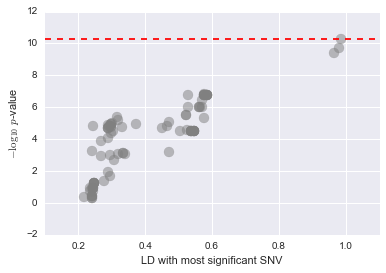

In [34]:
gid = sig_single.index[10]
ld_vs_pval(gid)

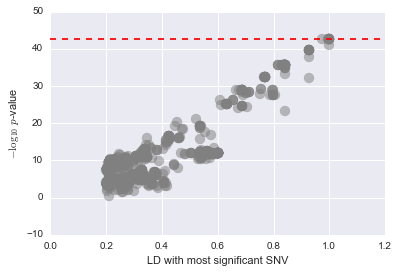

In [35]:
gid = sig_single.index[20]
ld_vs_pval(gid)

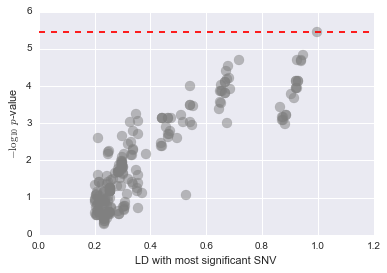

In [36]:
gid = sig_single.index[40]
ld_vs_pval(gid)

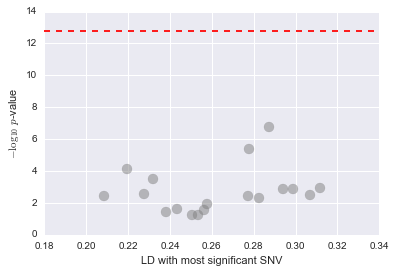

In [37]:
gid = sig_single.index[50]
ld_vs_pval(gid)

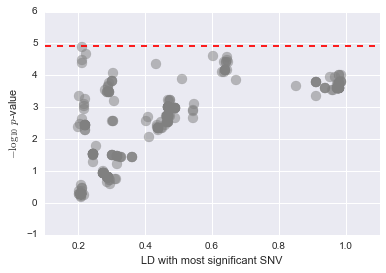

In [38]:
gid = sig_single.index[60]
ld_vs_pval(gid)

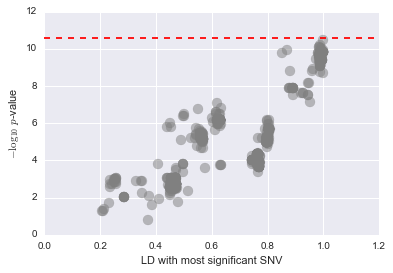

In [39]:
gid = sig_single.index[130]
ld_vs_pval(gid)

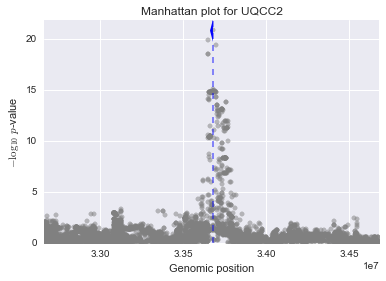

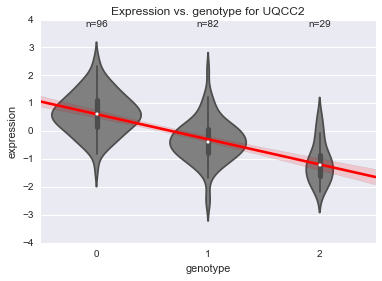

In [40]:
eqtl_summary(sig_single.index[0])

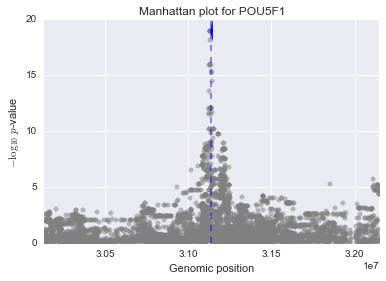

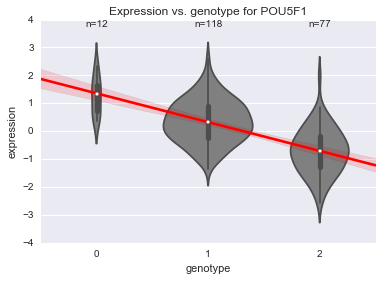

In [41]:
eqtl_summary(gene_info[gene_info.gene_name == 'POU5F1'].index[0])

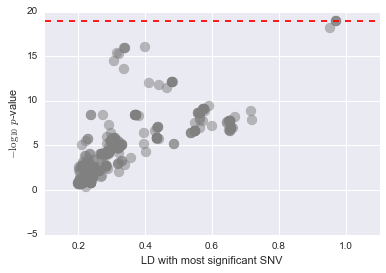

In [42]:
ld_vs_pval(gene_info[gene_info.gene_name == 'POU5F1'].index[0])

In [43]:
gene_info[gene_info.gene_name == 'POU5F1']

,gene_name,gene_type,chrom,start,end,strand,gene_status,source,level
gene_id,,,,,,,,,
ENSG00000204531.11,POU5F1,protein_coding,chr6,31132118,31148508,-,KNOWN,HAVANA,1


In [44]:
sig_single.ix[gene_info[gene_info.gene_name == 'POU5F1'].index[0]]

chrom                                 chr6
start                             31135171
end                               31135172
loc                          chr6:31135172
gene                    ENSG00000204531.11
marker_id         6:31135172_T/A_rs3130930
ns                                     207
ac                                     272
callrate                                 1
genocnt                          12/118/77
maf                                  0.343
stat                              -10.0966
pvalue                           1.068e-19
beta                                -1.023
sebeta                              0.1013
r2                                  0.3332
ref                                      T
alt                                      A
length                                   0
vtype                                  snp
tss_dist                              -225
tss_gene                ENSG00000204531.11
tss_transcript           ENST00000513407.1
tss        

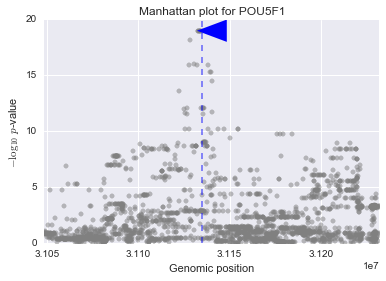

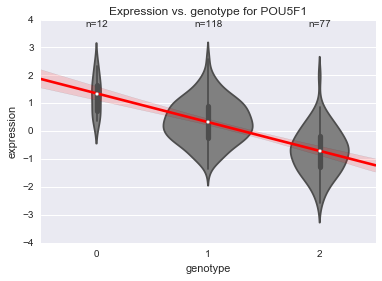

In [45]:
eqtl_summary(gene_info[gene_info.gene_name == 'POU5F1'].index[0], 
             left=100000, right=100000)